In [1]:
from Grayscale import apply_grayscale
from Threshold import binarize
import os
import numpy as np
import pandas as pd
from PIL import Image

In [17]:
# wykrywanie źrenicy
# image = Image.open('./MMU-Iris-Database/1/left/aeval1.bmp')
image = Image.open('./MMU-Iris-Database/35/left/suzailil1.bmp')
image_array = np.array(image)

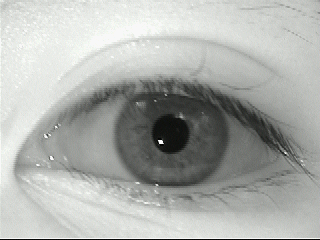

In [18]:
image

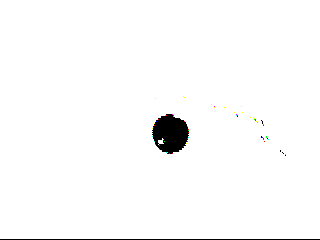

In [19]:
Image.fromarray(binarize(image_array, .07))